<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load data</a></span></li></ul></li><li><span><a href="#Figure-5b---Categories-of-combined-iModulons" data-toc-modified-id="Figure-5b---Categories-of-combined-iModulons-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 5b - Categories of combined iModulons</a></span></li><li><span><a href="#Create-RBH-graph" data-toc-modified-id="Create-RBH-graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create RBH graph</a></span></li><li><span><a href="#Figure-5c---Presence/absence-of-iModulons" data-toc-modified-id="Figure-5c---Presence/absence-of-iModulons-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Figure 5c - Presence/absence of iModulons</a></span></li><li><span><a href="#Figure-5d---Heatmap" data-toc-modified-id="Figure-5d---Heatmap-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Figure 5d - Heatmap</a></span></li><li><span><a href="#Figure-5e---Explained-variance" data-toc-modified-id="Figure-5e---Explained-variance-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Figure 5e - Explained variance</a></span></li><li><span><a href="#Figure-5f---ppGpp-Activities" data-toc-modified-id="Figure-5f---ppGpp-Activities-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Figure 5f - ppGpp Activities</a></span></li><li><span><a href="#Figure-5g:-PCA-of-datasets" data-toc-modified-id="Figure-5g:-PCA-of-datasets-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Figure 5g: PCA of datasets</a></span></li><li><span><a href="#Figure-5h:-PCA-of-activites" data-toc-modified-id="Figure-5h:-PCA-of-activites-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Figure 5h: PCA of activites</a></span></li><li><span><a href="#Supplementary-Figure-7" data-toc-modified-id="Supplementary-Figure-7-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Supplementary Figure 7</a></span><ul class="toc-item"><li><span><a href="#Panel-a:-Explained-variance-of-lost-i-modulons" data-toc-modified-id="Panel-a:-Explained-variance-of-lost-i-modulons-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Panel a: Explained variance of lost i-modulons</a></span></li><li><span><a href="#Panel-b:-Classes-of-new-i-modulons" data-toc-modified-id="Panel-b:-Classes-of-new-i-modulons-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Panel b: Classes of new i-modulons</a></span></li><li><span><a href="#Panel-c:-Histogram-of-IC-gene-coefficients" data-toc-modified-id="Panel-c:-Histogram-of-IC-gene-coefficients-10.3"><span class="toc-item-num">10.3&nbsp;&nbsp;</span>Panel c: Histogram of IC gene coefficients</a></span></li><li><span><a href="#Panel-e:-F1-score-chart" data-toc-modified-id="Panel-e:-F1-score-chart-10.4"><span class="toc-item-num">10.4&nbsp;&nbsp;</span>Panel e: F1-score chart</a></span></li><li><span><a href="#Panel-f:-Pearson-R-between-activities" data-toc-modified-id="Panel-f:-Pearson-R-between-activities-10.5"><span class="toc-item-num">10.5&nbsp;&nbsp;</span>Panel f: Pearson R between activities</a></span></li></ul></li><li><span><a href="#New-biological-component" data-toc-modified-id="New-biological-component-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>New biological component</a></span></li></ul></div>

# Setup

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import os, sys
from itertools import combinations
import seaborn as sns
from matplotlib_venn import venn2
from scipy import stats
from sklearn.decomposition import PCA
sys.path.append('../../scripts/')
from core import *

In [2]:
sns.set_style('ticks')

In [3]:
# Use custom stylesheet for figures
plt.style.use('custom')

## Load data

In [7]:
datasets = sorted([x for x in os.listdir(os.path.join(DATA_DIR,'iModulons'))
            if '.' not in x])

In [8]:
# Thresholds were obtained from sensitivity analysis
cutoffs = {'MA-1': 550,
 'MA-2': 600,
 'MA-3': 350,
 'RNAseq-1': 700,
 'RNAseq-2': 300,
 'combined': 400}

In [9]:
def load(dataset):
    # Define directories
    ds_dir = os.path.join(DATA_DIR,'iModulons',dataset)
    
    # Define files
    X_file = os.path.join(DATA_DIR,'processed_data',dataset+'_bc.csv')
    M_file = os.path.join(ds_dir,'M.csv')
    A_file = os.path.join(ds_dir,'A.csv')
    metadata_file = os.path.join(DATA_DIR,'metadata',dataset+'_metadata.csv')
    
    return IcaData(M_file,A_file,X_file,metadata_file,cutoffs[dataset])

In [10]:
# Load datasets
objs = {}
for ds in tqdm(datasets):
    objs[ds] = load(ds)

In [11]:
DF_categories = pd.read_csv(os.path.join(DATA_DIR,'iModulons','categories_curated.csv'),index_col=0)
DF_categories.index = DF_categories.dataset.combine(DF_categories.component,lambda x1,x2:x1+'_'+str(x2))

# Figure 5b - Categories of combined iModulons

In [12]:
data = DF_categories[DF_categories.dataset=='combined'].type.value_counts()
data

regulatory         108
uncharacterized     36
functional          22
genomic             15
Name: type, dtype: int64

In [13]:
data.sum()

181

In [14]:
data/data.sum()

regulatory         0.596685
uncharacterized    0.198895
functional         0.121547
genomic            0.082873
Name: type, dtype: float64

In [15]:
unchar_mod_lens = []
mod_lens = []
for k in objs['combined'].M.columns:
    if DF_categories.loc['combined_'+str(k),'type']=='uncharacterized':
        unchar_mod_lens.append(len(objs['combined'].show_enriched(k)))
    else:
        mod_lens.append(len(objs['combined'].show_enriched(k)))

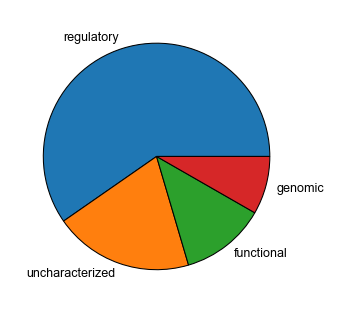

In [16]:
data = DF_categories[DF_categories.dataset=='combined'].type.value_counts()
plt.pie(data.values,labels=data.index);

# Create RBH graph

In [17]:
from rbh import *

In [18]:
l2s = []
for ds in datasets[:-1]:
    links = rbh(objs['combined'].M,objs[ds].M)
    for i,j,val in links:
        comp1 = 'combined'+'_'+str(i)
        comp2 = ds+'_'+str(j)
        class1 = DF_categories.loc[comp1,'type']
        class2 = DF_categories.loc[comp2,'type']
        desc1 = DF_categories.loc[comp1,'description']
        desc2 = DF_categories.loc[comp2,'description']
        l2s.append(['combined',ds,i,j,comp1,comp2,class1,class2,desc1,desc2,1-val])
DF_links = pd.DataFrame(l2s,columns=['ds1','ds2','comp1','comp2','name1','name2','type1','type2','desc1','desc2','dist'])
DF_links = DF_links[DF_links.dist > 0.3]

../../scripts/rbh.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  return np.dot(s1.T,s2)/np.sqrt((s1**2).sum())[:, np.newaxis]/np.sqrt((s2**2).sum())[np.newaxis,:]


In [19]:
DF_links = DF_links.sort_values(['ds1','comp1','ds2'])

In [20]:
DF_links[DF_links.type1 == 'uncharacterized'].name1.value_counts()

combined_147    4
combined_82     3
combined_157    3
combined_44     2
combined_45     2
combined_13     2
combined_27     2
combined_35     2
combined_71     2
combined_121    2
combined_11     2
combined_21     1
combined_180    1
combined_139    1
combined_90     1
combined_6      1
combined_107    1
combined_177    1
combined_77     1
combined_43     1
Name: name1, dtype: int64

In [21]:
# Total links between full dataset and individual datasets
DF_links.groupby('ds2').count()['ds1']

ds2
MA-1        51
MA-2        44
MA-3        19
RNAseq-1    87
RNAseq-2    43
Name: ds1, dtype: int64

In [22]:
# Average distance between full dataset and individual datasets
means = DF_links.groupby('ds2').mean()['dist']
stds = DF_links.groupby('ds2').std()['dist']

In [23]:
DF_links.to_csv(os.path.join(DATA_DIR,'iModulons','RBH_combined.csv'))

In [24]:
DF_links

,ds1,ds2,comp1,comp2,name1,name2,type1,type2,desc1,desc2,dist
138,combined,RNAseq-1,0,24,combined_0,RNAseq-1_24,regulatory,regulatory,lrp,lrp,0.733699
0,combined,MA-1,1,36,combined_1,MA-1_36,regulatory,regulatory,tdcR,tdcR,0.560505
60,combined,MA-2,1,39,combined_1,MA-2_39,regulatory,regulatory,tdcR,tdcA,0.455823
228,combined,RNAseq-2,1,50,combined_1,RNAseq-2_50,regulatory,regulatory,tdcR,tdcA,0.513089
139,combined,RNAseq-1,2,12,combined_2,RNAseq-1_12,genomic,genomic,b3751|b1337|b1338|b1339|b1340|b1341|b1342|b134...,b3751|b1337|b1338|b1339|b1340|b1341|b1342|b134...,0.937527
...,...,...,...,...,...,...,...,...,...,...,...
275,combined,RNAseq-2,173,49,combined_173,RNAseq-2_49,functional,uncharacterized,L-arginine import across plasma membrane,NaN,0.589533
226,combined,RNAseq-1,174,39,combined_174,RNAseq-1_39,functional,functional,cytosolic large ribosomal subunit,cytosolic large ribosomal subunit,0.914878
227,combined,RNAseq-1,175,86,combined_175,RNAseq-1_86,genomic,genomic,b1658,b1658|b4252,0.410324
276,combined,RNAseq-2,177,11,combined_177,RNAseq-2_11,uncharacterized,regulatory,NaN,lrp,0.507412


# Figure 5c - Presence/absence of iModulons

In [25]:
index = objs['combined'].M.columns

In [26]:
type_dict = {'regulatory':-2,'functional':-3,'genomic':-4,'uncharacterized':-5}

In [27]:
DF_binarized = pd.DataFrame([1]*len(index),index=index,columns=['Combined Compendium'])
for ds in datasets[:-1]:
    DF_binarized[ds] = [x in DF_links[DF_links.ds2==ds].comp1.tolist() for x in index]
DF_binarized = DF_binarized.astype(int)

DF_binarized['total'] = DF_binarized.sum(axis=1)

DF_binarized = (DF_binarized-1)
DF_binarized = DF_binarized[['RNAseq-1','RNAseq-2','MA-1','MA-2','MA-3','total']]

In [28]:
DF_binarized['type'] = [type_dict[DF_categories.loc['combined_'+str(k)].type] for k in DF_binarized.index]

In [29]:
DF_binarized = DF_binarized.sort_values(['total','RNAseq-1','RNAseq-2','MA-1','MA-2','MA-3','type'],ascending=False)

In [30]:
cmap = ['#b4d66c','#bc80b7','#81b1d3','#f47f72'] + ['white','black'] + sns.color_palette('Blues',5)

In [31]:
bin_counts = DF_binarized.groupby(['total','type']).size().unstack(fill_value=0).T.sort_index(ascending=False)
bin_counts = bin_counts
bin_counts.index = ['regulatory','biological','genomic','uncharacterized']

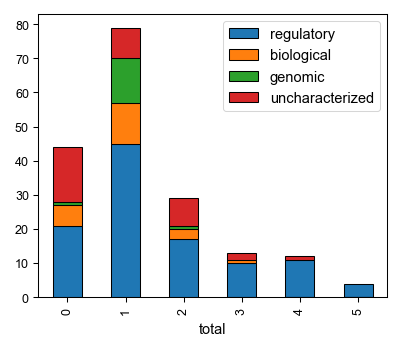

In [32]:
bin_counts.T.plot.bar(stacked=True)
plt.legend(bbox_to_anchor=(1,1))

In [33]:
print('Number of comps:',len(DF_binarized))
print('Number of linked comps: {} ({:.2f})'.format(sum(DF_binarized.total > 0),
                                       sum(DF_binarized.total > 0)/len(DF_binarized)))

Number of comps: 181
Number of linked comps: 137 (0.76)


In [34]:
print('Number of linked comps: {} ({:.2f})'.format(sum(DF_binarized.total >1),
                                       sum(DF_binarized.total > 1)/len(DF_binarized)))

Number of linked comps: 58 (0.32)


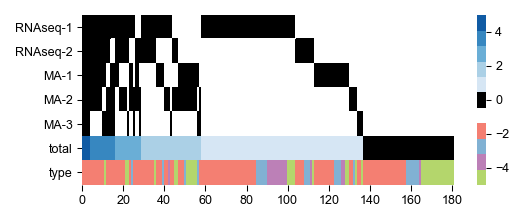

In [35]:
fig,ax = plt.subplots(figsize=(4,1.5))
sns.heatmap(DF_binarized.T,cmap=cmap,ax=ax)
ax.set_xticks(np.arange(len(DF_binarized),step=20));
ax.tick_params(axis='x',reset=True,length=3,width=.5,color='k',top=False)
ax.set_xticklabels(np.arange(len(DF_binarized),step=20),);

# Figure 5d - Heatmap

<AxesSubplot:xlabel='type', ylabel='dataset'>

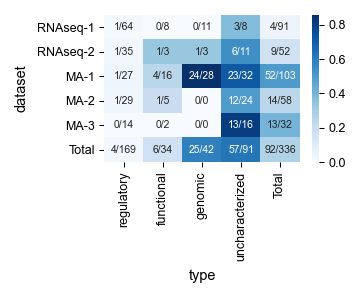

In [36]:
fig,ax = plt.subplots(figsize=(2.1,1.3))

DF_types = DF_categories.groupby(['dataset','type']).count().component.unstack().fillna(0).drop('combined')
DF_types.loc['Total'] = DF_types.sum(axis=0)
DF_types['Total'] = DF_types.sum(axis=1)

DF_types_linked = DF_links.groupby(['ds2','type2']).count().comp1.unstack().fillna(0)
DF_types_linked.loc['Total'] = DF_types_linked.sum(axis=0)
DF_types_linked['Total'] = DF_types_linked.sum(axis=1)

DF_types_lost = DF_types - DF_types_linked

DF_text = pd.DataFrame()
for col in DF_types_lost:
    DF_text[col] = DF_types_lost[col].astype(int).astype(str).str.cat(DF_types[col].astype(int).astype(str),sep='/')
DF_text = DF_text[['regulatory','functional','genomic','uncharacterized','Total']]

type_grid = (DF_types_lost/DF_types).fillna(0)[['regulatory','functional','genomic','uncharacterized','Total']]

type_grid = type_grid.reindex(['RNAseq-1','RNAseq-2','MA-1','MA-2','MA-3','Total'])
DF_text = DF_text.reindex(['RNAseq-1','RNAseq-2','MA-1','MA-2','MA-3','Total'])

sns.heatmap(type_grid,cmap='Blues',annot=DF_text,fmt='s',annot_kws={"size": 5})

In [37]:
# Types lost
DF_lost = DF_types- DF_types_linked
DF_lost

type,functional,genomic,regulatory,uncharacterized,Total
dataset,,,,,
MA-1,4.0,24.0,1.0,23.0,52.0
MA-2,1.0,0.0,1.0,12.0,14.0
MA-3,0.0,0.0,0.0,13.0,13.0
RNAseq-1,0.0,0.0,1.0,3.0,4.0
RNAseq-2,1.0,1.0,1.0,6.0,9.0
Total,6.0,25.0,4.0,57.0,92.0


In [38]:
DF_types_linked.loc['Total']

type2
functional          28.0
genomic             17.0
regulatory         165.0
uncharacterized     34.0
Total              244.0
Name: Total, dtype: float64

In [39]:
DF_types_linked.loc['Total']/DF_types_linked.loc['Total'].iloc[:-1].sum()

type2
functional         0.114754
genomic            0.069672
regulatory         0.676230
uncharacterized    0.139344
Total              1.000000
Name: Total, dtype: float64

# Figure 5e - Explained variance

In [43]:
# Load dataset - Downloaded from Sanchez-Vasquez et al 2019
DF_ppGpp = pd.read_excel(os.path.join(DATA_DIR,'ppGpp_data','dataset_s01_from_sanchez_vasquez_2019.xlsx'),sheet_name='Data')

# Get 757 genes described to be directly regulated by ppGpp
paper_genes = DF_ppGpp[DF_ppGpp['1+2+ 5 min Category'].isin(['A','B'])].Synonym.values
len(paper_genes)

757

In [44]:
paper_genes_down = DF_ppGpp[DF_ppGpp['1+2+ 5 min Category'].isin(['A'])].Synonym.values

In [45]:
paper_genes_up = DF_ppGpp[DF_ppGpp['1+2+ 5 min Category'].isin(['B'])].Synonym.values

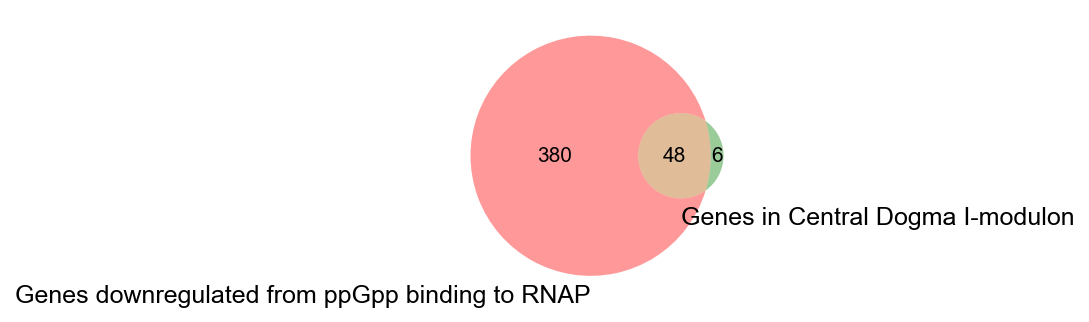

In [49]:
venn2((set(paper_genes_down),set(objs['combined'].show_enriched(147).index)),set_labels=('Genes downregulated from ppGpp binding to RNAP','Genes in Central Dogma I-modulon'))

In [52]:
pp_genes = {}
for k in objs['combined'].M.columns:
    pp_genes[k] = set(objs['combined'].show_enriched(k).index) & set(paper_genes)

In [54]:
set(objs['combined'].show_enriched(147).index) - set(paper_genes)

{'b0142', 'b1435', 'b1660', 'b2069', 'b3643_1', 'b3778'}

# Figure 5f - ppGpp Activities

In [56]:
ppGpp_X = pd.read_csv(os.path.join(DATA_DIR,'ppGpp_data','log_tpm_norm.csv'),index_col=0)

# Get genes in both ICA data and ppGpp dataframe
shared_genes = sorted(set(objs['combined'].X.index) & set(ppGpp_X.index))

# Keep only genes in both dataframes
ppGpp_X = ppGpp_X.loc[shared_genes]
M = objs['combined'].M.loc[shared_genes]

# Center columns
X = ppGpp_X.sub(ppGpp_X.mean(axis=0))

In [57]:
# Perform projection
M_inv = np.linalg.pinv(M)
A = np.dot(M_inv,X)
A = pd.DataFrame(A,columns = X.columns, index = M.columns)

In [58]:
t0 = ['ppgpp__t0__1','ppgpp__t0__2','ppgpp__t0__3']
t5 = ['ppgpp__t5__1','ppgpp__t5__2','ppgpp__t5__3']

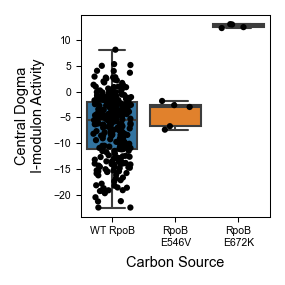

In [62]:
ds4 = objs['combined'].metadata[objs['combined'].metadata['dataset'] == 'RNAseq-1'].index
df = pd.DataFrame(objs['combined'].A.loc[147,ds4])
df['group'] = ['RpoB\nE672K' if 'rpoBE672K' in x else 'RpoB\nE546V' if 'rpoBE546V' in x else 'WT RpoB' for x in df.index]

fig,ax = plt.subplots(figsize=(2,2))
sns.boxplot(data=df,y=147,x='group')
sns.stripplot(data=df,y=147,x='group',dodge=True,color='k',jitter=0.3,s=3)
ax.set_ylabel('Central Dogma\nI-modulon Activity',fontsize=7)
ax.set_xlabel('Carbon Source',fontsize=7)
ax.tick_params(labelsize=5)
plt.tight_layout()

# Figure 5g: PCA of datasets

In [65]:
cdict = dict(zip(datasets[:-1],['tab:orange','black','tab:red','tab:green','tab:blue']))

In [69]:
exp_data = pd.read_csv(os.path.join(DATA_DIR,'processed_data','combined_bc.csv'),index_col=0)

pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(exp_data.T),index=exp_data.columns)
DF_components = pd.DataFrame(pca.components_.T,index=exp_data.index)
var_cutoff = 0.99

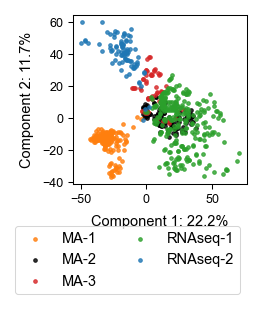

In [70]:
fig,ax = plt.subplots(figsize=(1.5,1.5))
for name,group in objs['combined'].metadata.groupby('dataset'):
    idx = exp_data.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               c=cdict[name],
               label=name,alpha=0.8,s=3)
ax.set_xlabel('Component 1: %.1f%%'%(pca.explained_variance_ratio_[0]*100))
ax.set_ylabel('Component 2: %.1f%%'%(pca.explained_variance_ratio_[1]*100))
ax.legend(bbox_to_anchor=(1,-.2),ncol=2)

# Figure 5h: PCA of activites

In [75]:
pca = PCA()
DF_weights = pd.DataFrame(pca.fit_transform(objs['combined'].A.T),index=objs['combined'].A.columns)
DF_components = pd.DataFrame(pca.components_.T,index=objs['combined'].A.index)
var_cutoff = 0.99

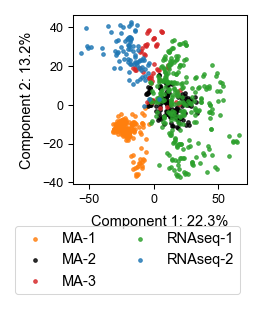

In [76]:
fig,ax = plt.subplots(figsize=(1.5,1.5))
for name,group in objs['combined'].metadata.groupby('dataset'):
    idx = exp_data.loc[:,group.index.tolist()].columns.tolist()
    ax.scatter(DF_weights.loc[idx,0],
               DF_weights.loc[idx,1],
               c=cdict[name],
               label=name,alpha=0.8,s=3)
ax.set_xlabel('Component 1: %.1f%%'%(pca.explained_variance_ratio_[0]*100))
ax.set_ylabel('Component 2: %.1f%%'%(pca.explained_variance_ratio_[1]*100))
ax.legend(bbox_to_anchor=(1,-.2),ncol=2)

# Supplementary Figure 7

## Panel a: Explained variance of lost i-modulons

In [77]:
kept_mods = set(DF_links.name2.unique())

In [78]:
all_mods = set([ds+'_'+str(name) for ds in datasets[:-1] for name in objs[ds].M.columns])

In [79]:
missing_mods = all_mods - kept_mods

In [80]:
from util import plot_rec_var

In [81]:
missing_var = []
for mod in tqdm(missing_mods):
    ds,comp = mod.split('_')
    missing_var.append(plot_rec_var(objs[ds],modulons=[int(comp)],plot=False).values[0])
    if plot_rec_var(objs[ds],modulons=[int(comp)],plot=False).values[0] > 10:
        print(mod)
    
kept_var = []
for mod in tqdm(kept_mods):
    ds,comp = mod.split('_')
    kept_var.append(plot_rec_var(objs[ds],modulons=[int(comp)],plot=False).values[0])

MA-2_43



Text(0, 0.5, 'Count')

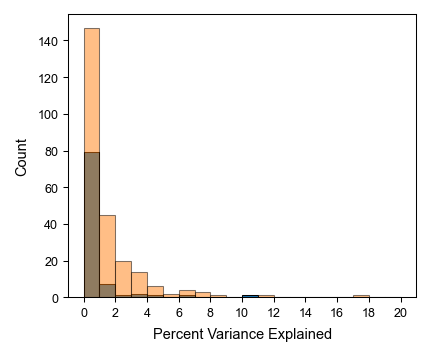

In [82]:
plt.hist(missing_var,range=(0,20),bins=20)
plt.hist(kept_var,range=(0,20),bins=20,alpha=0.5)
plt.xticks(range(0,21,2))
plt.xlabel('Percent Variance Explained')
plt.ylabel('Count')

In [83]:
stats.mannwhitneyu(missing_var,kept_var)

MannwhitneyuResult(statistic=5770.0, pvalue=3.2439299584357683e-12)

Text(0, 0.5, 'Count')

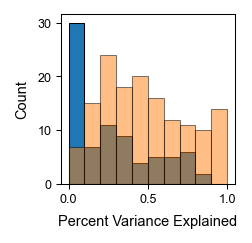

In [84]:
fig,ax = plt.subplots(figsize=(1.5,1.5))
plt.hist(missing_var,range=(0,1),bins=10)
plt.hist(kept_var,range=(0,1),bins=10,alpha=0.5)
plt.xlabel('Percent Variance Explained')
plt.ylabel('Count')

## Panel b: Classes of new i-modulons

In [85]:
type_dict

{'regulatory': -2, 'functional': -3, 'genomic': -4, 'uncharacterized': -5}

In [86]:
new_counts = DF_binarized[(DF_binarized.total==0)].type.value_counts()
new_counts

-2    21
-5    16
-3     6
-4     1
Name: type, dtype: int64

In [87]:
new_reg = DF_binarized[(DF_binarized.total==0) & (DF_binarized.type==-2)].index
new_bio = DF_binarized[(DF_binarized.total==0) & (DF_binarized.type==-3)].index
new_gen = DF_binarized[(DF_binarized.total==0) & (DF_binarized.type==-4)].index
new_unc = DF_binarized[(DF_binarized.total==0) & (DF_binarized.type==-5)].index

In [88]:
new_single = []
for k in new_unc:
    if objs['combined'].show_enriched(k)['weight'].max() > 0.4:
        new_single.append(k)

In [89]:
[len(new_reg),len(new_bio),len(new_gen),len(new_unc)-len(new_single),len(new_single)]

[21, 6, 1, 4, 12]

([<matplotlib.patches.Wedge at 0x7f1ebb7b87c0>,
 [Text(0.07847312953561776, 1.0971973240675017, 'Regulatory'),
  Text(-1.055442282845914, -0.3099057721001753, 'Functional'),
  Text(-0.777817477511334, -0.7778174410990703, 'Genomic'),
  Text(-0.456956527076959, -1.0005951890558762, 'Uncharacterized'),
  Text(0.7203468250294088, -0.8313245164615624, 'Single Gene')])

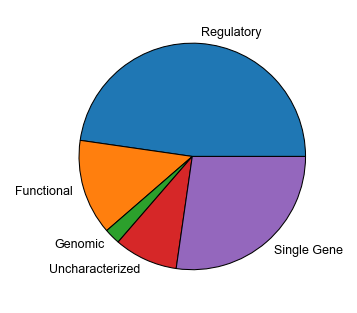

In [90]:
plt.pie([len(new_reg),len(new_bio),len(new_gen),len(new_unc)-len(new_single),len(new_single)],
        labels=['Regulatory','Functional','Genomic','Uncharacterized','Single Gene'])

## Panel c: Histogram of IC gene coefficients

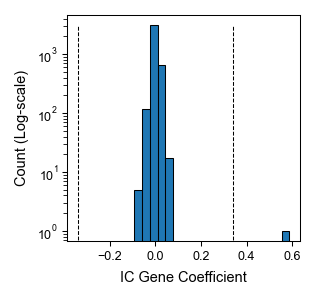

In [91]:
fig,ax = plt.subplots(figsize=(2,2))
plt.hist(objs['combined'].M[31])
plt.yscale('log')
plt.xlabel('IC Gene Coefficient')
plt.ylabel('Count (Log-scale)')
plt.vlines([objs['combined'].thresholds[31],-objs['combined'].thresholds[31]],0,3000,
           linestyles='dashed',linewidth=0.5)

## Panel e: F1-score chart

In [92]:
reg_links = DF_links[(DF_links.type1 == 'regulatory') & (DF_links.desc1 == DF_links.desc2)]
reg_links.head()

,ds1,ds2,comp1,comp2,name1,name2,type1,type2,desc1,desc2,dist
138,combined,RNAseq-1,0,24,combined_0,RNAseq-1_24,regulatory,regulatory,lrp,lrp,0.733699
0,combined,MA-1,1,36,combined_1,MA-1_36,regulatory,regulatory,tdcR,tdcR,0.560505
2,combined,MA-1,3,58,combined_3,MA-1_58,regulatory,regulatory,purR,purR,0.463571
112,combined,MA-3,3,31,combined_3,MA-3_31,regulatory,regulatory,purR,purR,0.608821
140,combined,RNAseq-1,3,59,combined_3,RNAseq-1_59,regulatory,regulatory,purR,purR,0.877769


<AxesSubplot:xlabel='variable', ylabel='value'>

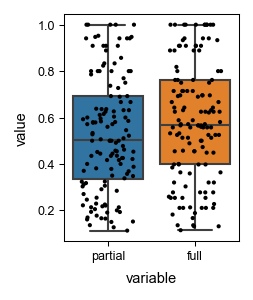

In [93]:
fig,ax=plt.subplots(figsize=(1.5,2))
struct = []
for name,group in reg_links.groupby('ds2'):
    struct.append(pd.DataFrame(list(zip([name]*len(group),
                          DF_categories.loc[group.name1,'f1score'].values,
                          DF_categories.loc[group.name2,'f1score'].values)),
                      columns=['title','full','partial']))
DF_stats = pd.concat(struct)
DF_stats = DF_stats.melt(id_vars='title')
sns.boxplot(data=DF_stats,x='variable',y='value',order=['partial','full'])
sns.stripplot(data=DF_stats,x='variable',y='value',color='k',s=2,jitter=0.3,order=['partial','full'])

In [94]:
DF_stats[DF_stats.variable=='partial'].value.mean()

0.529029852282844

In [95]:
DF_stats[DF_stats.variable=='full'].value.mean()

0.5812389872946475

In [96]:
stats.wilcoxon(DF_stats[DF_stats.variable=='partial'].value,DF_stats[DF_stats.variable=='full'].value)

WilcoxonResult(statistic=1952.5, pvalue=0.00011421109990313254)

## Panel f: Pearson R between activities

In [97]:
from sklearn.metrics import r2_score

In [98]:
linked_pearson = []
for i,row in DF_links.iterrows():
    partial_acts = objs[row.ds2].A.loc[row.comp2]
    full_acts = objs[row.ds1].A.loc[row.comp1,partial_acts.index]
    r,_ = stats.spearmanr(full_acts,partial_acts)
    linked_pearson.append(abs(r))

In [99]:
sum(np.array(linked_pearson) > 0.6) / len(linked_pearson)

0.8934426229508197

Text(0, 0.5, 'Count')

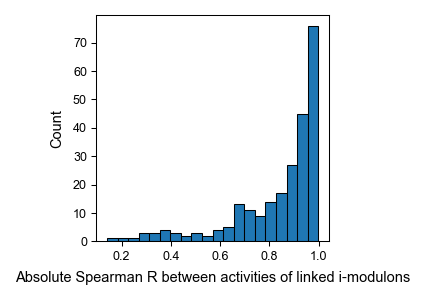

In [100]:
fig,ax = plt.subplots(figsize=(2,2))
ax.hist(linked_pearson,bins=20)
ax.set_xlabel('Absolute Spearman R between activities of linked i-modulons')
ax.set_ylabel('Count')

# New biological component

In [104]:
rRNA = 0
tRNA = 0
ygene = 0
polyamine = 0
for gene in objs['combined'].show_enriched(147)['product']:
    if 'rRNA' in gene or 'ribosom' in gene:
        rRNA += 1
    elif 'tRNA' in gene:
        tRNA += 1
    elif 'putative' in gene or 'family' in gene:
        ygene += 1
    elif 'spermidine' in gene or 'YEEF' in gene:
        polyamine +=1
    else:
        print(gene)

G6999-MONOMER
RNase P protein component
ATP-dependent DNA helicase Rep
inner membrane protein YhbE
ATP-dependent RNA helicase DbpA
long-chain fatty acid outer membrane channel / bacteriophage T2 receptor
YICE-MONOMER
SDAC-MONOMER
N<sup>6</sup>-L-threonylcarbamoyladenine synthase, TsaB subunit
H2PTERIDINEPYROPHOSPHOKIN-MONOMER
GTPase ObgE
poly(A) polymerase I
Kdo<sub>2</sub>-lipid A phosphotransferase
LYSP-MONOMER
lipid II flippase MurJ
DUF2594 domain-containing protein YecF
orotidine-5'-phosphate decarboxylase
ATP-dependent RNA helicase SrmB
RNA polymerase-binding ATPase and RNAP recycling factor
truncated RNase PH
inosine/guanosine kinase
EG10812-MONOMER
ATP-dependent RNA helicase RhlE
EF-P-lysine lysyltransferase
inositol-phosphate phosphatase
DNA-binding transcriptional dual regulator Fis


In [103]:
objs['combined'].show_enriched(147)

,weight,gene_name,product,start,stop,strand,operon,length,cog
b1055,0.052977,trhO,tRNA U34 hydroxylase TrhO,1116807,1117859,+,trhO,1053,Function unknown
b1821,0.053614,mntP,G6999-MONOMER,1905688,1906254,+,mntP,567,Function unknown
b0661,0.054178,miaB,isopentenyl-adenosine A37 tRNA methylthiolase,693531,694955,-,miaB,1425,"Translation, ribosomal structure and biogenesis"
b3704,0.055265,rnpA,RNase P protein component,3884493,3884852,+,rnpA;rpmH,360,"Translation, ribosomal structure and biogenesis"
b3778,0.058383,rep,ATP-dependent DNA helicase Rep,3960677,3962698,+,rep,2022,"Replication, recombination and repair"
b3184,0.059469,yhbE,inner membrane protein YhbE,3331770,3332735,-,obgE;yhbE;rpmA;rplU,966,Amino acid transport and metabolism
b0905,0.060194,ycaO,ribosomal protein S12 methylthiotransferase ac...,954872,956632,-,ycaO,1761,Function unknown
b1343,0.060353,dbpA,ATP-dependent RNA helicase DbpA,1409511,1410884,+,dbpA,1374,"Replication, recombination and repair"
b2344,0.060368,fadL,long-chain fatty acid outer membrane channel /...,2461306,2462646,+,fadL,1341,Lipid transport and metabolism
b3871,0.060565,bipA,"ribosome-dependent GTPase, ribosome assembly f...",4058407,4060230,+,bipA,1824,Signal transduction mechanisms
